In [1]:
# Add this at the beginning of your notebook
!pip install -q kagglehub transformers torch torchvision pillow matplotlib pandas tqdm
# Check if GPU is available
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.6 MB/s eta 0:00:00
Using device: cuda


In [2]:
import kagglehub
adityajn105_flickr8k_path = kagglehub.dataset_download('adityajn105/flickr8k')


print('Data source import complete.')

100%|██████████| 1.04G/1.04G [00:26<00:00, 41.6MB/s]

Extracting files...


Data source import complete.


In [3]:
import kagglehub
import os

# Download the dataset (only need to do this once)
dataset_path = kagglehub.dataset_download('adityajn105/flickr8k')
print(f"Dataset path: {dataset_path}")

# Define your paths
image_dir = os.path.join(dataset_path, "Images")
caption_path = os.path.join(dataset_path, "captions.txt")

Dataset path: /root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1


In [4]:
import os

# Define the correct dataset path
dataset_path = "/root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1"

# List all folders and files inside the dataset path
dataset_contents = os.listdir(dataset_path)

# Print dataset contents
print("Dataset contents:")
for item in dataset_contents:
    print(item)

Dataset contents:
captions.txt
Images


In [5]:
# Mount Google Drive for saving checkpoints
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [6]:
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader

# Load captions more efficiently
captions_df = pd.read_csv(caption_path)
image_captions = {}

# Get captions organized by image
for _, row in captions_df.iterrows():
    img_name, caption = row[captions_df.columns[0]], row[captions_df.columns[1]]
    if img_name not in image_captions:
        image_captions[img_name] = []
    image_captions[img_name].append(caption)

# Custom dataset with on-the-fly processing
class Flickr8kDataset(Dataset):
    def __init__(self, image_dir, image_captions, feature_extractor, tokenizer, max_length=50):
        self.image_dir = image_dir
        # Create image-caption pairs for training
        self.samples = []
        for img_name, captions in image_captions.items():
            for caption in captions:
                self.samples.append((img_name, caption))

        self.feature_extractor = feature_extractor
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_name, caption = self.samples[idx]
        img_path = os.path.join(self.image_dir, img_name)

        # Load and process image on-the-fly
        image = Image.open(img_path).convert("RGB")
        pixel_values = self.feature_extractor(images=image, return_tensors="pt").pixel_values.squeeze(0)

        # Process caption
        tokenized = self.tokenizer(
            caption,
            padding="max_length",
            max_length=self.max_length,
            truncation=True,
            return_tensors="pt"
        )

        return {
            "pixel_values": pixel_values,
            "labels": tokenized.input_ids.squeeze(0),
            "attention_mask": tokenized.attention_mask.squeeze(0)
        }

In [7]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer

# Load tokenizer and image processor
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # Set pad token
feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

# Initialize model (smaller variant to fit in memory)
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.61k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/982M [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.49.0"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id"

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(i

In [8]:
# Load checkpoint
checkpoint_path = '/content/drive/MyDrive/image_caption_models/checkpoint_epoch7_step10000.pt'
checkpoint = torch.load(checkpoint_path, map_location=device)

In [9]:
from transformers.optimization import AdamW
import torch.nn as nn # if your model uses torch layers
# Prepare dataset
dataset = Flickr8kDataset(image_dir, image_captions, feature_extractor, tokenizer)


# Modify your DataLoader with these optimizations
dataloader = DataLoader(
    dataset,
    batch_size=4,  # Reduce batch size but use gradient accumulation
    shuffle=True,
    num_workers=2,
    pin_memory=True,  # Faster data transfer to GPU
    persistent_workers=True
)

# Update training config
optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)
gradient_accumulation_steps = 4  # Simulates batch_size=16

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [10]:
# Restore model and optimizer states
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [11]:
from transformers.optimization import AdamW
import torch.nn as nn # if your model uses torch layers
# Prepare dataset
dataset = Flickr8kDataset(image_dir, image_captions, feature_extractor, tokenizer)


# Modify your DataLoader with these optimizations
dataloader = DataLoader(
    dataset,
    batch_size=4,  # Reduce batch size but use gradient accumulation
    shuffle=True,
    num_workers=2,
    pin_memory=True,  # Faster data transfer to GPU
    persistent_workers=True
)

# Update training config
optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)
gradient_accumulation_steps = 4  # Simulates batch_size=16

In [12]:
# First, let's install necessary packages
!pip install torchmetrics nltk pycocoevalcap

import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

from torchmetrics.text.bleu import BLEUScore
# We'll use pycocoevalcap for METEOR and CIDEr since they're not in torchmetrics
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.cider.cider import Cider
from sklearn.model_selection import train_test_split
from torch.optim import AdamW
from tqdm.notebook import tqdm
import time
import os
import shutil
import glob

# Define save path for your model in Google Drive
DRIVE_SAVE_PATH = '/content/drive/MyDrive/image_caption_models'

# Create directory if it doesn't exist
os.makedirs(DRIVE_SAVE_PATH, exist_ok=True)

# Function to clean up old checkpoints, keeping only the N most recent
def cleanup_checkpoints(keep_last_n=2):
    checkpoint_files = [
        f for f in glob.glob(os.path.join(DRIVE_SAVE_PATH, "checkpoint_epoch*_step*.pt"))
        if "epoch7_step10000" not in f  # Protect resuming checkpoint
    ]
    checkpoint_files.sort(key=os.path.getmtime)

    files_to_delete = checkpoint_files[:-keep_last_n] if len(checkpoint_files) > keep_last_n else []
    for file in files_to_delete:
        try:
            os.remove(file)
            print(f"Deleted old checkpoint: {os.path.basename(file)}")
        except Exception as e:
            print(f"Error deleting {file}: {e}")

    # Also clean up any intermediate models (not the best ones)
    intermediate_files = glob.glob(os.path.join(DRIVE_SAVE_PATH, "latest_model.pt"))
    # Keep only the last one
    if len(intermediate_files) > 1:
        intermediate_files.sort(key=os.path.getmtime)
        for file in intermediate_files[:-1]:
            try:
                os.remove(file)
                print(f"Deleted intermediate model: {os.path.basename(file)}")
            except Exception as e:
                print(f"Error deleting {file}: {e}")

# 1. Split dataset into train/validation
all_images = list(image_captions.keys())
train_images, val_images = train_test_split(all_images, test_size=0.1, random_state=42)
# Create validation samples (5% of data for quick evaluation)
val_samples = {img: image_captions[img] for img in val_images[:50]}  # Use first 50 for validation

# 2. Implement evaluation function with BLEU, CIDEr, and METEOR
def evaluate_metrics(model, val_samples, tokenizer, max_eval=50):
    model.eval()
    bleu = BLEUScore(n_gram=4)
    meteor_scorer = Meteor()
    cider_scorer = Cider()

    # For storing results
    scores = {
        'bleu': 0.0,
        'meteor': 0.0,
        'cider': 0.0
    }

    # For collecting all generated captions and references (needed for CIDEr and METEOR)
    all_generated = {}
    all_references = {}

    count = 0
    with torch.no_grad():
        for img_idx, (img_name, ref_captions) in enumerate(list(val_samples.items())[:max_eval]):
            img_path = os.path.join(image_dir, img_name)
            # Process image
            image = Image.open(img_path).convert("RGB")
            pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)
            # Generate caption
            output_ids = model.generate(
                pixel_values,
                max_length=50,
                num_beams=3,
                early_stopping=True
            )
            # Decode and clean
            generated = tokenizer.decode(output_ids[0], skip_special_tokens=True)
            references = [cap.replace("<start>", "").replace("<end>", "").strip() for cap in ref_captions]

            # Store for CIDEr and METEOR calculation
            img_id = str(img_idx)
            all_generated[img_id] = [generated]
            all_references[img_id] = references

            # Calculate BLEU per image
            scores['bleu'] += bleu([generated], [[ref] for ref in references])

            count += 1

    # Calculate METEOR and CIDEr for all images at once
    meteor_score, _ = meteor_scorer.compute_score(all_references, all_generated)
    cider_score, _ = cider_scorer.compute_score(all_references, all_generated)

    scores['meteor'] = meteor_score
    scores['cider'] = cider_score

    # Average BLEU score
    scores['bleu'] /= count

    return scores
# Function to save model to Google Drive and clean up previous versions
def save_model_to_drive(model, filename, drive_path=DRIVE_SAVE_PATH):
    # First save the model to a temporary local file
    local_path = f'/content/{filename}'
    torch.save(model.state_dict(), local_path)

    # Full path in Google Drive
    drive_file_path = os.path.join(drive_path, filename)

    # Remove previous version if it exists
    if os.path.exists(drive_file_path):
        os.remove(drive_file_path)

    # Copy the new model to Drive
    shutil.copy(local_path, drive_file_path)

    # Remove the local copy to free space
    os.remove(local_path)

    print(f"Model saved to Google Drive at: {drive_file_path}")

    return drive_file_path


best_score = 0.8098
patience = 2

# Save path for checkpoints
checkpoint_filename = 'best_model.pt'

# Clean up any existing checkpoints at the start
cleanup_checkpoints(keep_last_n=1)


# Set starting epoch and step
start_epoch = checkpoint['epoch'] + 1  # Epoch 6
current_step = checkpoint['step']
print(f"Resuming from Epoch {start_epoch}, Step {current_step}")

# Modified training loop
for epoch in range(start_epoch, 8):  # Train until epoch 15
    model.train()
    total_loss = 0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}")

    # Only save checkpoint every 1000 steps to save space
    checkpoint_frequency = 1000

    # Skip already processed steps if resuming mid-epoch
    if epoch == start_epoch - 1:  # Only for first resumed epoch
        for _ in range(current_step):
            next(progress_bar)  # Fast-forward progress bar

    for step, batch in enumerate(progress_bar):
        # Existing training code remains the same
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Update progress
        total_loss += loss.item()
        progress_bar.set_postfix({"loss": loss.item()})

        # Periodically save checkpoint to drive (less frequently)
        if step > 0 and step % checkpoint_frequency == 0:
            temp_checkpoint_path = os.path.join(DRIVE_SAVE_PATH, f"checkpoint_epoch{epoch+1}_step{step}.pt")
            torch.save({
                'epoch': epoch,
                'step': step,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss.item(),
            }, temp_checkpoint_path)
            print(f"Checkpoint saved at step {step}")

            # Clean up old checkpoints
            cleanup_checkpoints(keep_last_n=1)  # Keep only the most recent checkpoint

    # Validation
    metric_scores = evaluate_metrics(model, val_samples, tokenizer)
    print(f"Epoch {epoch+1} - Validation scores:")
    print(f"  BLEU-4: {metric_scores['bleu']:.4f}")
    print(f"  METEOR: {metric_scores['meteor']:.4f}")
    print(f"  CIDEr: {metric_scores['cider']:.4f}")

    # Use a combined score for early stopping (weighted average)
    current_score = (0.4 * metric_scores['bleu'] + 0.3 * metric_scores['meteor'] + 0.3 * metric_scores['cider'])
    print(f"  Combined score: {current_score:.4f}")

    # Early stopping logic - use combined score
    if current_score > best_score:
        best_score = current_score

        # Save as the main best model, overwriting previous version
        save_model_to_drive(model, checkpoint_filename)

        # Save metrics in a separate file
        metrics_file = os.path.join(DRIVE_SAVE_PATH, "best_model_metrics.txt")
        with open(metrics_file, 'w') as f:
            f.write(f"BLEU-4: {metric_scores['bleu']:.4f}\n")
            f.write(f"METEOR: {metric_scores['meteor']:.4f}\n")
            f.write(f"CIDEr: {metric_scores['cider']:.4f}\n")
            f.write(f"Combined score: {current_score:.4f}\n")

        # Reset patience
        patience = 2
        print(f"New best model saved with combined score: {current_score:.4f}")
    else:
        patience -= 1

        # Save the current epoch's model, overwriting the previous non-best model
        intermediate_filename = f"latest_model.pt"
        save_model_to_drive(model, intermediate_filename)

        if patience == 0:
            print("Early stopping triggered!")
            break

print(f"Training complete. Best model saved with combined score: {best_score:.4f}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 10.6 MB/s eta 0:00:00


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Resuming from Epoch 7, Step 10000


Epoch 8:   0%|          | 0/10114 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


Checkpoint saved at step 1000
Checkpoint saved at step 2000
Deleted old checkpoint: checkpoint_epoch8_step1000.pt
Checkpoint saved at step 3000
Deleted old checkpoint: checkpoint_epoch8_step2000.pt
Checkpoint saved at step 4000
Deleted old checkpoint: checkpoint_epoch8_step3000.pt
Checkpoint saved at step 5000
Deleted old checkpoint: checkpoint_epoch8_step4000.pt
Checkpoint saved at step 6000
Deleted old checkpoint: checkpoint_epoch8_step5000.pt
Checkpoint saved at step 7000
Deleted old checkpoint: checkpoint_epoch8_step6000.pt
Checkpoint saved at step 8000
Deleted old checkpoint: checkpoint_epoch8_step7000.pt
Checkpoint saved at step 9000
Deleted old checkpoint: checkpoint_epoch8_step8000.pt
Checkpoint saved at step 10000
Deleted old checkpoint: checkpoint_epoch8_step9000.pt


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Epoch 8 - Validation scores:
  BLEU-4: 0.1142
  METEOR: 0.4395
  CIDEr: 2.0290
  Combined score: 0.7862
Model saved to Google Drive at: /content/drive/MyDrive/image_caption_models/latest_model.pt
Training complete. Best model saved with combined score: 0.8098


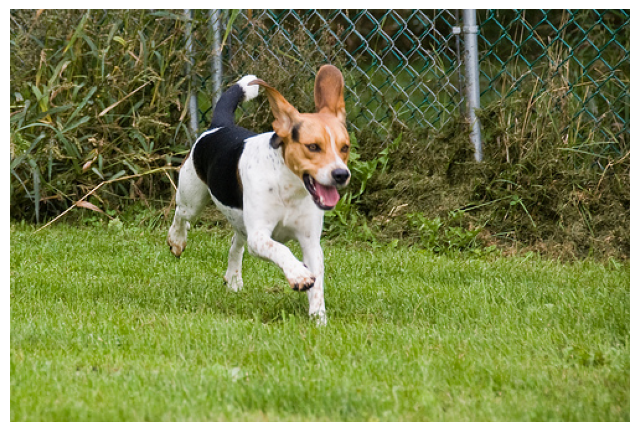

Image: 2886411666_72d8b12ce4.jpg
Actual Captions: ['a black , brown and white dog is running beside a green fence in a grassy garden .', 'A dog is galloping through the grass .', 'A dog runs through a lush , green lawn .', 'A tri-colored dog is running on the green grass .', 'Dog running through grass in fenced in area .']
Predicted Caption: A black and white dog is running through the grass .


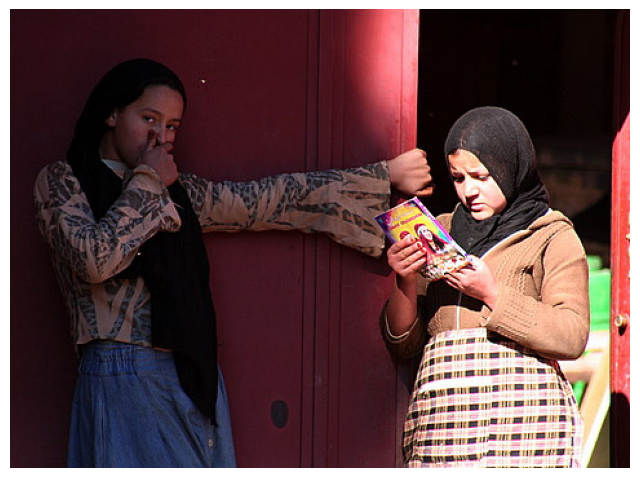

Image: 3182258223_5b9c8a8c55.jpg
Actual Captions: ['A woman in shadow looks at the camera while the one in the sun looks at a book .', 'Girl stands reading a notebook .', 'Two girls stand up against a red wall .', 'Two young girls with headscarves stand near a door while one reads a book .', 'Two young women wearing black head scarves and colorful skirts stand near a red door .']
Predicted Caption: A woman wearing a black headscarf looks at the camera while the one in the sun looks to the left .


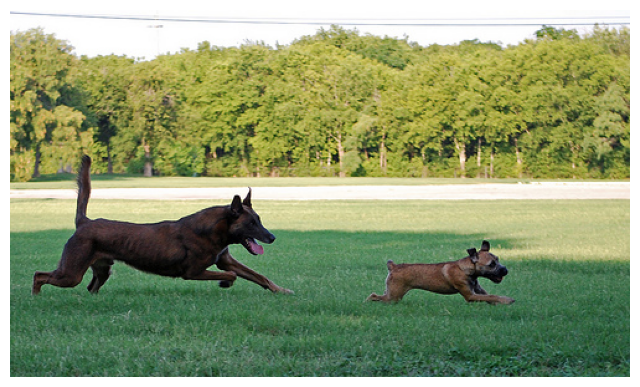

Image: 2723477522_d89f5ac62b.jpg
Actual Captions: ['A big dog chases a little dog on the grass .', 'A black dog is chasing a smaller brown dog over grass .', 'The large brown dog is chasing after the little brown dog .', 'Two brown dogs run through the grass together .', 'two dogs play in the grass .']
Predicted Caption: A large brown dog chases a small black dog across the grass .


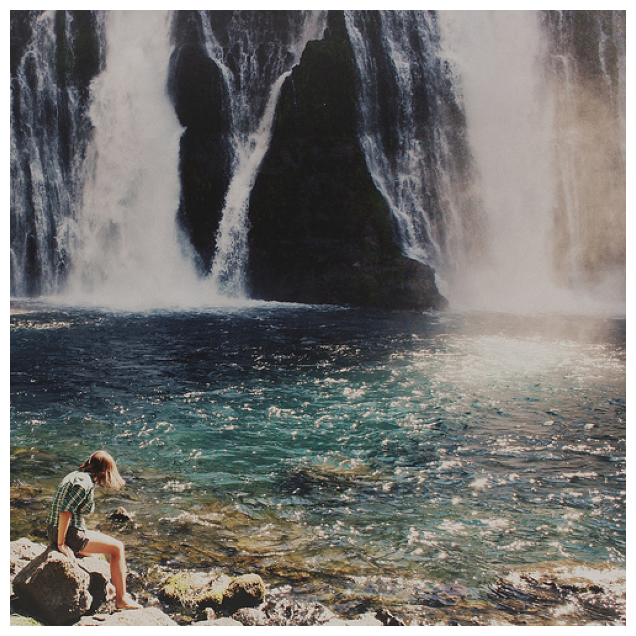

Image: 3715559023_70c41b31c7.jpg
Actual Captions: ['A girl is sitting on a rock next to a waterfall .', 'An onlooker sits on the shore of a pool overlooked by massive waterfalls .', 'A person sits on a rock at the edge of a large waterfall .', 'A person sitting on a rock by a fall .', 'A woman is sitting on a rock next to a large waterfall .']
Predicted Caption: A girl sits on a rock next to a large waterfall .


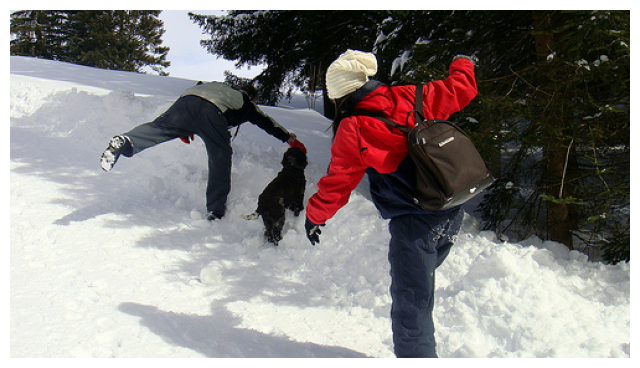

Image: 3339105374_cc41e0b7d7.jpg
Actual Captions: ['A woman in a red coat with a man in a white and black coat and a black dog in the snow .', 'Two people and a dog are in the snow .', 'Two people are interacting with a dog that has bitten an object one of them is holding .', 'Two people are walking up a snowy hill with a dog .', 'Two people playing on a snowy hill .']
Predicted Caption: Two people and a dog play in the snow .


In [13]:
import random
import matplotlib.pyplot as plt
from PIL import Image

# Function to visualize predictions for 5 random images
def visualize_random_predictions(model, tokenizer, val_samples, image_dir, num_samples=5):
    model.eval()
    with torch.no_grad():
        # Select 5 random images from the validation samples
        random_samples = random.sample(list(val_samples.items()), num_samples)

        for i, (img_name, ref_captions) in enumerate(random_samples):
            img_path = os.path.join(image_dir, img_name)
            # Load and display the image
            image = Image.open(img_path).convert("RGB")
            plt.figure(figsize=(8, 8))
            plt.imshow(image)
            plt.axis("off")
            plt.show()

            # Process image
            pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)
            # Generate caption
            output_ids = model.generate(
                pixel_values,
                max_length=50,
                num_beams=3,
                early_stopping=True
            )
            # Decode and clean the generated caption
            predicted_caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)
            actual_captions = [cap.replace("<start>", "").replace("<end>", "").strip() for cap in ref_captions]

            # Print the actual and predicted captions
            print(f"Image: {img_name}")
            print(f"Actual Captions: {actual_captions}")
            print(f"Predicted Caption: {predicted_caption}")
            print("="*50)

# Testing on 5 random images from the validation dataset
visualize_random_predictions(model, tokenizer, val_samples, image_dir, num_samples=5)
